In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
import random
import glob
import matplotlib.pyplot as plt
import cv2
import keras
# import tensorflow.contrib.slim as slim
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from collections import Counter
%matplotlib inline

ModuleNotFoundError: No module named 'keras'

In [61]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_data_generator= train_datagen.flow_from_directory("malaria",
                                                    target_size=(150, 150),
                                                    batch_size=32,
                                                    class_mode='binary',
                                                    subset = 'training')

Found 930 images belonging to 1 classes.


In [64]:
test_data_generator = train_datagen.flow_from_directory("malaria",
                                                    target_size=(150, 150),
                                                    batch_size=32,
                                                    class_mode='binary',
                                                    subset = 'validation')

Found 398 images belonging to 1 classes.


In [68]:
import tensorflow as tf

# Load the TensorBoard notebook extension (optional)
%load_ext tensorboard

tf.random.set_seed(42)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
BATCH_SIZE = 64
NUM_CLASSES = 2
EPOCHS = 25
INPUT_SHAPE =(125, 125, 3)

In [57]:
inp = tf.keras.layers.Input(shape=INPUT_SHAPE)

conv1 = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), 
                               activation='relu', padding='same')(inp)
pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), 
                               activation='relu', padding='same')(pool1)
pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = tf.keras.layers.Conv2D(128, kernel_size=(3, 3), 
                               activation='relu', padding='same')(pool2)
pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)

flat = tf.keras.layers.Flatten()(pool3)

hidden1 = tf.keras.layers.Dense(512, activation='relu')(flat)
drop1 = tf.keras.layers.Dropout(rate=0.3)(hidden1)
hidden2 = tf.keras.layers.Dense(512, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(rate=0.3)(hidden2)

out = tf.keras.layers.Dense(1, activation='sigmoid')(drop2)

model = tf.keras.Model(inputs=inp, outputs=out)
model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 125, 125, 3)]     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 125, 125, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 62, 62, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 31, 31, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 15, 15, 128)       0   

In [66]:
# Clear any logs from previous runs
!rm -rf ./logs/ 
%tensorboard 

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
Error: A logdir or db must be specified. For example `tensorboard --logdir mylogdir` or `tensorboard --db sqlite:~/.tensorboard.db`. Run `tensorboard --helpfull` for details and examples.

In [69]:
import datetime

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=2, min_lr=0.000001)
callbacks = [reduce_lr, tensorboard_callback]

history = model.fit_generator(generator=train_data_generator,
                              steps_per_epoch = len(train_data_generator),
                              epochs = 5,
                              validation_data = test_data_generator,
                              validation_steps = len(test_data_generator),
                              callbacks=callbacks,
                              verbose=1)     
                    

Epoch 1/5


InvalidArgumentError: ignored

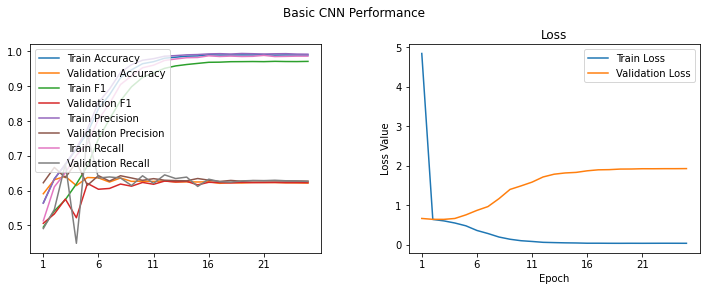

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))

max_epoch = len(history.history['f1'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, history.history['f1'], label='Train F1')
ax1.plot(epoch_list, history.history['val_f1'], label='Validation F1')

max_epoch = len(history.history['precision'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, history.history['precision'], label='Train Precision')
ax1.plot(epoch_list, history.history['val_precision'], label='Validation Precision')
ax1.set_xticks(np.arange(1, max_epoch, 5))

max_epoch = len(history.history['recall'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, history.history['recall'], label='Train Recall')
ax1.plot(epoch_list, history.history['val_recall'], label='Validation Recall')
ax1.set_xticks(np.arange(1, max_epoch, 5))


# # ax1.set_ylabel('Accuracy Value')
# # ax1.set_xlabel('Epoch')
# # ax1.set_title('Accuracy')

# 313230
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")




# ax1.set_ylabel('F1 score Value')
# ax1.set_xlabel('Epoch')
# ax1.set_title('F1 score')
l1 = ax1.legend(loc="best")

# max_epoch = len(history.history['precision'])+1
# epoch_list = list(range(1,max_epoch))
# ax1.plot(epoch_list, history.history['precision'], label='Train Precision')
# ax1.plot(epoch_list, history.history['val_precision'], label='Validation Precision')
# ax1.set_xticks(np.arange(1, max_epoch, 5))
# # ax1.set_ylabel('Precision Value')
# # ax1.set_xlabel('Epoch')
# # ax1.set_title('precision')
# l1 = ax1.legend(loc="best")

# max_epoch = len(history.history['recall'])+1
# epoch_list = list(range(1,max_epoch))
# ax1.plot(epoch_list, history.history['recall'], label='Train Recall')
# ax1.plot(epoch_list, history.history['val_recall'], label='Validation Recall')
# ax1.set_xticks(np.arange(1, max_epoch, 5))
# ax1.set_ylabel('Metrics Values')
# ax1.set_xlabel('Epoch')
# ax1.set_title('Metrics')
# l1 = ax1.legend(loc="best")

In [ ]:
# serialize model to JSON
model1 = model.to_json()
with open("history.json", "w") as json_file:
    json_file.write(model1)
# serialize weights to HDF5
model.save_weights("history.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
# Pre-trained Model as a Feature Extractor

vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet', 
                                        input_shape=INPUT_SHAPE)
vgg.trainable = False
# Freeze the layers
for layer in vgg.layers:
    layer.trainable = False
    
base_vgg = vgg
base_out = base_vgg.output
pool_out = tf.keras.layers.Flatten()(base_out)
hidden1 = tf.keras.layers.Dense(512, activation='relu')(pool_out)
drop1 = tf.keras.layers.Dropout(rate=0.3)(hidden1)
hidden2 = tf.keras.layers.Dense(512, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(rate=0.3)(hidden2)

out = tf.keras.layers.Dense(1, activation='sigmoid')(drop2)

model_vgg = tf.keras.Model(inputs=base_vgg.input, outputs=out)
model_vgg.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
                loss='binary_crossentropy',
                metrics=['accuracy'])
model_vgg.summary()


80142336/80134624 [==============================] - 1s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 125, 125, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 125, 125, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 125, 125, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 62, 62, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 62, 62, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 62, 62, 128)       147584    
____________________________________________________________

In [ ]:
print("Total Layers:", len(model_vgg.layers))
print("Total trainable layers:", 
      sum([1 for l in model_vgg.layers if l.trainable]))

Total Layers: 28
Total trainable layers: 6


In [ ]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=2, min_lr=0.000001)
callbacks = [reduce_lr, tensorboard_callback]

results = model_vgg.fit(x=train_data, y=np.array(train_labels_enc), 
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split = 0.3,
                    validation_data=(val_data, val_labels_enc), 
                    callbacks=callbacks,
                    verbose=1)
                    

Epoch 1/25
190/190 [==============================] - 19s 103ms/step - loss: 0.9053 - accuracy: 0.8259 - val_loss: 0.3007 - val_accuracy: 0.9086 - lr: 1.0000e-04
Epoch 2/25
190/190 [==============================] - 18s 95ms/step - loss: 0.3754 - accuracy: 0.8882 - val_loss: 0.2547 - val_accuracy: 0.9184 - lr: 1.0000e-04
Epoch 3/25
190/190 [==============================] - 18s 95ms/step - loss: 0.2781 - accuracy: 0.9090 - val_loss: 0.2477 - val_accuracy: 0.9199 - lr: 1.0000e-04
Epoch 4/25
190/190 [==============================] - 18s 95ms/step - loss: 0.2263 - accuracy: 0.9262 - val_loss: 0.2648 - val_accuracy: 0.9148 - lr: 1.0000e-04
Epoch 5/25
190/190 [==============================] - 18s 95ms/step - loss: 0.1870 - accuracy: 0.9352 - val_loss: 0.2441 - val_accuracy: 0.9282 - lr: 1.0000e-04
Epoch 6/25
190/190 [==============================] - 18s 95ms/step - loss: 0.1711 - accuracy: 0.9421 - val_loss: 0.2391 - val_accuracy: 0.9294 - lr: 1.0000e-04
Epoch 7/25
190/190 [=============

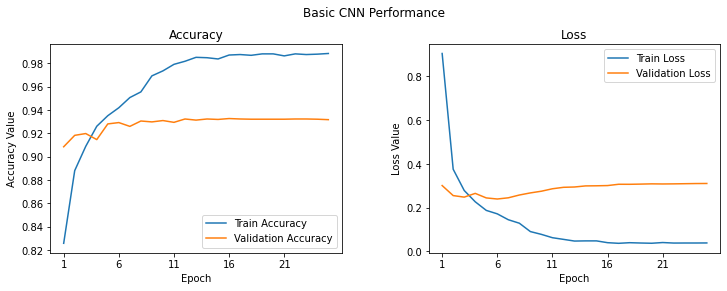

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(results.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, results.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, results.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, results.history['loss'], label='Train Loss')
ax2.plot(epoch_list, results.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")


In [ ]:
# Image Augmentation

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                zoom_range=0.05, 
                                                                rotation_range=25,
                                                                width_shift_range=0.05, 
                                                                height_shift_range=0.05, 
                                                                shear_range=0.05, horizontal_flip=True, 
                                                                fill_mode='nearest')

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# build image augmentation generators
train_generator = train_datagen.flow(train_data, train_labels_enc, batch_size=BATCH_SIZE, shuffle=True)
val_generator = val_datagen.flow(val_data, val_labels_enc, batch_size=BATCH_SIZE, shuffle=False)

Labels: ['malaria', 'malaria', 'malaria', 'malaria', 'malaria']


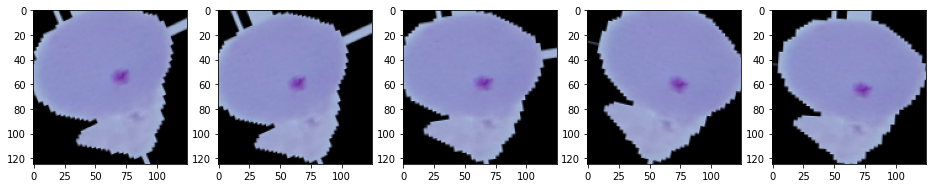

In [ ]:
img_id = 0
sample_generator = train_datagen.flow(train_data[img_id:img_id+1], train_labels[img_id:img_id+1],
                                      batch_size=1)
sample = [next(sample_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(16, 6))
print('Labels:', [item[1][0] for item in sample])
l = [ax[i].imshow(sample[i][0][0]) for i in range(0,5)]

In [ ]:
# Fine-tuning VGG19

vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet', 
                                        input_shape=INPUT_SHAPE)
# Freeze the layers
vgg.trainable = True

set_trainable = False
for layer in vgg.layers:
    if layer.name in ['block5_conv1', 'block4_conv1']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
    
base_vgg = vgg
base_out = base_vgg.output
pool_out = tf.keras.layers.Flatten()(base_out)
hidden1 = tf.keras.layers.Dense(512, activation='relu')(pool_out)
drop1 = tf.keras.layers.Dropout(rate=0.3)(hidden1)
hidden2 = tf.keras.layers.Dense(512, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(rate=0.3)(hidden2)
out = tf.keras.layers.Dense(1, activation='sigmoid')(drop2)

model_ft = tf.keras.Model(inputs=base_vgg.input, outputs=out)
model_ft.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-5),
                loss='binary_crossentropy',
                metrics=['accuracy'])

In [ ]:
import datetime

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=2, min_lr=0.000001)
callbacks = [reduce_lr, tensorboard_callback]
train_steps_per_epoch = train_generator.n // train_generator.batch_size
val_steps_per_epoch = val_generator.n // val_generator.batch_size
results_ft = model_ft.fit_generator(train_generator, steps_per_epoch=train_steps_per_epoch, epochs=EPOCHS,
                              validation_data=val_generator, validation_steps=val_steps_per_epoch, 
                              verbose=1)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/25
271/271 [==============================] - 61s 224ms/step - loss: 0.2279 - accuracy: 0.9074 - val_loss: 0.1251 - val_accuracy: 0.9594
Epoch 2/25
271/271 [==============================] - 60s 223ms/step - loss: 0.1387 - accuracy: 0.9533 - val_loss: 0.1074 - val_accuracy: 0.9630
Epoch 3/25
271/271 [==============================] - 61s 224ms/step - loss: 0.1250 - accuracy: 0.9573 - val_loss: 0.1011 - val_accuracy: 0.9661
Epoch 4/25
271/271 [==============================] - 61s 225ms/step - loss: 0.1186 - accuracy: 0.9590 - val_loss: 0.0981 - val_accuracy: 0.9656
Epoch 5/25
271/271 [==============================] - 61s 226ms/step - loss: 0.1121 - accuracy: 0.9594 - val_loss: 0.0992 - val_accuracy: 0.9651
Epoch 6/25
271/271 [==============================] - 61s 226ms/step - loss: 0.1060 - accuracy: 0.9636 - val_loss: 0.1021 - val_accuracy: 0.9667
Epoch 7/25
271/271 [==============================] - 

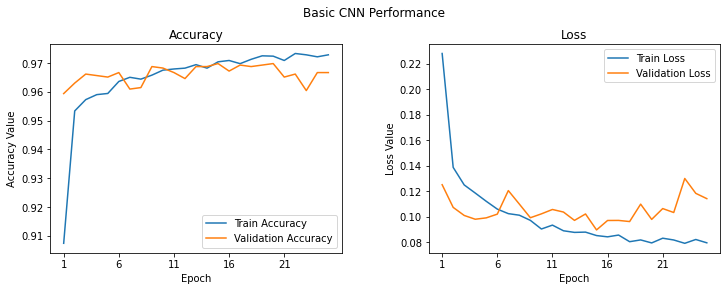

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(results_ft.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, results_ft.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, results_ft.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, results_ft.history['loss'], label='Train Loss')
ax2.plot(epoch_list, results_ft.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")